1. Imports & Global Settings

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from lightgbm import LGBMClassifier
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from joblib import dump

warnings.filterwarnings('ignore', category=FutureWarning)
plt.style.use('seaborn-v0_8-whitegrid')

2. Data Loading, Time-of-Day Bucketing & Round Assignment

In [2]:
usecols = [
    'Time','HomeTeam','AwayTeam','FTHG','FTAG','FTR','Referee',
    'HS','AS','HST','AST','HF','AF','HC','AC','HY','AY','HR','AR',
    'B365H','B365D','B365A','B365>2.5','B365<2.5'
]
file_path = r"D:\python\premier league predictor\premier league data\premier leaguer 22-23.csv"
df = pd.read_csv(file_path, usecols=usecols)

df['MatchIndex'] = df.index + 1
df['Round']      = np.ceil(df['MatchIndex'] / 10).astype(int)

df['Hour'] = pd.to_datetime(df['Time'], format='%H:%M', errors='coerce').dt.hour
bins   = [-1, 11, 17, 24]
labels = ['Morning','Afternoon','Evening']
df['TimeOfDay'] = pd.cut(df['Hour'], bins=bins, labels=labels)
df.drop(columns='Hour', inplace=True)

print("Loaded shape:", df.shape)

Loaded shape: (380, 27)


3. Leakage-Free Feature Engineering

In [3]:
# 3.1 Targets
df['Outcome']  = df['FTR'].map({'H': 1, 'D': 0, 'A': -1})
df['Over2.5']  = ((df['FTHG'] + df['FTAG']) >= 3).astype(int)

# 3.2 Implied probabilities from odds
for side in ['H', 'D', 'A']:
    df[f'ImpProb_{side}'] = 1.0 / df[f'B365{side}']
prob_cols = ['ImpProb_H', 'ImpProb_D', 'ImpProb_A']
df[prob_cols] = df[prob_cols].div(df[prob_cols].sum(axis=1), axis=0)

df['ImpOver2.5']  = 1.0 / df['B365>2.5']
df['ImpUnder2.5'] = 1.0 / df['B365<2.5']
df[['ImpOver2.5', 'ImpUnder2.5']] = (
    df[['ImpOver2.5', 'ImpUnder2.5']]
      .div(df[['ImpOver2.5', 'ImpUnder2.5']].sum(axis=1), axis=0)
)

# 3.3 Odds spread
df['OddsSpread'] = df['B365H'] - df['B365A']

# 3.4 Rolling 3-match form
df['HomeForm3'] = (
    df.groupby('HomeTeam')['Outcome']
      .transform(lambda s: s.shift(1).rolling(3, min_periods=1).mean())
)
df['AwayForm3'] = (
    df.groupby('AwayTeam')['Outcome']
      .transform(lambda s: s.shift(1).rolling(3, min_periods=1).mean())
)

# 3.5 Win/Loss streaks
df['HomeStreak'] = (
    df.groupby('HomeTeam')['Outcome']
      .transform(lambda s: 
          s.eq(1).shift(1).fillna(0).astype(int)
           .groupby((~s.eq(1)).cumsum()).cumsum()
      )
)
df['AwayStreak'] = (
    df.groupby('AwayTeam')['Outcome']
      .transform(lambda s: 
          s.eq(-1).shift(1).fillna(0).astype(int)
           .groupby((~s.eq(-1)).cumsum()).cumsum()
      )
)

# 3.6 Interaction
df['Spread×Form'] = df['OddsSpread'] * df['HomeForm3']

# 3.7 Referee home-bias
df['RefHomeWins'] = (
    df.groupby('Referee')['Outcome']
      .transform(lambda s: s.eq(1).cumsum().shift(1).fillna(0))
)
df['RefMatches'] = df.groupby('Referee').cumcount()
df['RefBias']    = (df['RefHomeWins'] / df['RefMatches']).fillna(0.5)
df.drop(columns=['RefHomeWins', 'RefMatches'], inplace=True)

# 3.8 Head-to-head last result
df['PairKey'] = df.apply(
    lambda r: tuple(sorted([r.HomeTeam, r.AwayTeam])), axis=1
)
h2h = {}
def prev_h2h(row):
    key = row.PairKey
    prev = h2h.get(key, 0)
    sign = 1 if row.HomeTeam == key[0] else -1
    h2h[key] = row.Outcome * sign
    return prev

df['H2H_Last'] = df.apply(prev_h2h, axis=1)
df.drop(columns='PairKey', inplace=True)

# 3.9 Rolling averages of match stats
home_stats = ['HS', 'HST', 'HF', 'HC', 'HY', 'HR']
away_stats = ['AS','AST','AF','AC','AY','AR']
for stat in home_stats:
    df[f'Home_{stat}_3'] = (
        df.groupby('HomeTeam')[stat]
          .transform(lambda s: s.shift(1).rolling(3, min_periods=1).mean())
    )
for stat in away_stats:
    df[f'Away_{stat}_3'] = (
        df.groupby('AwayTeam')[stat]
          .transform(lambda s: s.shift(1).rolling(3, min_periods=1).mean())
    )

# 3.10 Previous-round table positions
df['HomePts'] = np.where(df['FTR'] == 'H', 3, np.where(df['FTR'] == 'D', 1, 0))
df['AwayPts'] = np.where(df['FTR'] == 'A', 3, np.where(df['FTR'] == 'D', 1, 0))

pts = pd.DataFrame({
    'Team':  np.concatenate([df['HomeTeam'], df['AwayTeam']]),
    'Round': np.concatenate([df['Round'],    df['Round']]),
    'Pts':   np.concatenate([df['HomePts'],   df['AwayPts']])
})
round_pts = (
    pts
    .groupby(['Team','Round'], as_index=False)['Pts']
    .sum()
)
round_pts['CumPts'] = round_pts.groupby('Team')['Pts'].cumsum()
round_pts['Pos']    = (
    round_pts
    .groupby('Round')['CumPts']
    .rank(method='min', ascending=False)
)
prev = round_pts[['Team','Round','Pos']].copy()
prev.rename(columns={'Round':'PrevRound','Pos':'PrevPos'}, inplace=True)
prev['PrevRound'] += 1

df = df.merge(
    prev, left_on=['HomeTeam','Round'],
    right_on=['Team','PrevRound'], how='left'
)
df['HomePosPrev'] = df['PrevPos'].fillna(df['Round'].max() + 1)
df.drop(columns=['Team','PrevRound','PrevPos'], inplace=True)

df = df.merge(
    prev, left_on=['AwayTeam','Round'],
    right_on=['Team','PrevRound'], how='left'
)
df['AwayPosPrev'] = df['PrevPos'].fillna(df['Round'].max() + 1)
df.drop(columns=['Team','PrevRound','PrevPos'], inplace=True)

4. Pipeline Specification & Hyperparameter Distributions

In [4]:
import numpy as np
import lightgbm as lgb
from lightgbm import LGBMClassifier
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from scipy.stats import loguniform, uniform, randint

# 4.0) safety: ensure feature lists exist (if 3rd point not executed)
if 'cat_feats' not in globals() or 'num_feats' not in globals():
    cat_feats = [c for c in ['HomeTeam','AwayTeam','Referee','TimeOfDay'] if c in df.columns]
    core_num = [
        'HomeForm3','AwayForm3','HomeStreak','AwayStreak',
        'ImpProb_H','ImpProb_D','ImpProb_A',
        'ImpOver2.5','ImpUnder2.5',
        'OddsSpread','Spread×Form','RefBias','H2H_Last',
        'HomePosPrev','AwayPosPrev'
    ]
    core_num = [c for c in core_num if c in df.columns]
    home_stats = ['HS','HST','HF','HC','HY','HR']
    away_stats = ['AS','AST','AF','AC','AY','AR']
    roll_num = [f'Home_{s}_3' for s in home_stats if f'Home_{s}_3' in df.columns] + \
               [f'Away_{s}_3' for s in away_stats if f'Away_{s}_3' in df.columns]
    num_feats = core_num + roll_num

# 4.1) safety: ensure category dtype for the categorical columns
for c in ['HomeTeam','AwayTeam','Referee','TimeOfDay']:
    if c in df.columns and df[c].dtype.name != 'category':
        df[c] = df[c].astype('category')

# 4.2) base model (multiclass, early stopping via callbacks; balanced classes)
base_params = dict(
    objective='multiclass',
    num_class=3,
    class_weight='balanced',       # handle H/D/A imbalance
    n_estimators=3000,             # high cap, early stopping will cut it
    learning_rate=0.03,
    max_depth=-1,                  # unlimited, controlled by num_leaves/min_data_in_leaf
    num_leaves=63,
    min_data_in_leaf=20,
    feature_fraction=0.8,
    bagging_fraction=0.8,
    bagging_freq=1,
    lambda_l1=0.0,
    lambda_l2=0.0,
    random_state=42,
    verbose=-1,
    n_jobs=-1
)

def make_lgbm():
    # sklearn API supports categorical_feature by name (recent versions).
    # We'll pass it at fit-time to stay version-safe.
    return LGBMClassifier(**base_params)

# 4.3) search space (compact but expressive)
param_distributions = {
    'learning_rate'    : loguniform(1e-2, 1e-1),   # 0.01..0.1
    'num_leaves'       : randint(31, 256),         # capacity
    'min_data_in_leaf' : randint(10, 101),         # regularization
    'feature_fraction' : uniform(0.6, 0.4),        # 0.6..1.0
    'bagging_fraction' : uniform(0.6, 0.4),        # 0.6..1.0
    'bagging_freq'     : randint(1, 8),            # 1..7
    'lambda_l1'        : loguniform(1e-4, 10),     # L1
    'lambda_l2'        : loguniform(1e-4, 10),     # L2
    # Optional cap on depth if overfitting: uncomment next line
    # 'max_depth'      : [-1, 8, 10, 12],
}

tscv = TimeSeriesSplit(n_splits=3)
scorers = {'bal_acc': 'balanced_accuracy', 'acc': 'accuracy'}  # compromise

def make_rand_search_lgbm():
    return RandomizedSearchCV(
        estimator=make_lgbm(),
        param_distributions=param_distributions,
        n_iter=30,                  # 20–40: trade-off speed vs quality
        cv=tscv,
        scoring=scorers,
        refit='bal_acc',
        n_jobs=1,                   # important: let LGBM use threads internally
        random_state=42,
        verbose=0
    )

5. Round-by-Round Training & Prediction with Tuning

In [5]:
from sklearn.metrics import accuracy_score
import numpy as np
import lightgbm as lgb

# containers
preds, actuals, rounds, match_indices = [], [], [], []

# warm-up
WARMUP_ROUNDS = 5
WARMUP_MATCHES = WARMUP_ROUNDS * 10

X_warm = df.loc[:WARMUP_MATCHES-1, cat_feats + num_feats]
y_warm = df.loc[:WARMUP_MATCHES-1, 'Outcome']

# simple warm-up fit with early stopping eval (use last warm-up round as val)
val_mask_w = (df['Round'] == WARMUP_ROUNDS) & (df.index < WARMUP_MATCHES)
if val_mask_w.sum() >= 10:
    X_tr_w = df.loc[(df.index < WARMUP_MATCHES) & (~val_mask_w), cat_feats + num_feats]
    y_tr_w = df.loc[(df.index < WARMUP_MATCHES) & (~val_mask_w), 'Outcome']
    X_val_w = df.loc[val_mask_w, cat_feats + num_feats]
    y_val_w = df.loc[val_mask_w, 'Outcome']
else:
    split_idx = int(len(X_warm) * 0.9)
    X_tr_w, y_tr_w = X_warm.iloc[:split_idx], y_warm.iloc[:split_idx]
    X_val_w, y_val_w = X_warm.iloc[split_idx:], y_warm.iloc[split_idx:]

warm_model = make_lgbm()
_ = warm_model.fit(
    X_tr_w, y_tr_w,
    categorical_feature=cat_feats,
    eval_set=[(X_val_w, y_val_w)],
    eval_metric='multi_logloss',  # neutral; selection happens via CV scoring outside
    callbacks=[lgb.early_stopping(50, verbose=False)]
)

# predict from round 6 onward
max_round = int(df['Round'].max())
for r in range(WARMUP_ROUNDS + 1, max_round + 1):
    train_mask = df['Round'] < r
    test_mask  = df['Round'] == r

    X_train = df.loc[train_mask, cat_feats + num_feats]
    y_train = df.loc[train_mask, 'Outcome']

    round_df = df.loc[test_mask, :].sort_values(['Round', 'MatchIndex'])
    if len(round_df) > 10:
        round_df = round_df.head(10)
    if len(round_df) < 10:
        print(f"Round {r}: only {len(round_df)} matches available → skipped.")
        continue

    X_test = round_df[cat_feats + num_feats]
    y_test = round_df['Outcome']

    # validation = last completed round before r, else 90/10 split
    val_round = r - 1
    val_mask = (df['Round'] == val_round) & train_mask
    if val_mask.sum() >= 10:
        X_val = df.loc[val_mask, cat_feats + num_feats]
        y_val = df.loc[val_mask, 'Outcome']
        train_mask_adj = train_mask & (~val_mask)
        X_train = df.loc[train_mask_adj, cat_feats + num_feats]
        y_train = df.loc[train_mask_adj, 'Outcome']
    else:
        split_idx = int(len(X_train) * 0.9)
        X_val = X_train.iloc[split_idx:]
        y_val = y_train.iloc[split_idx:]
        X_train = X_train.iloc[:split_idx]
        y_train = y_train.iloc[:split_idx]

    print(f"Round {r}: training={len(X_train)} | val={len(X_val)} | test=10 ...")

    # randomized search (multi-metric, refit on balanced accuracy)
    rand_search = make_rand_search_lgbm()
    rand_search.fit(
        X_train, y_train,
        categorical_feature=cat_feats,                 # pass categoricals
        eval_set=[(X_val, y_val)],
        eval_metric='multi_logloss',
        callbacks=[lgb.early_stopping(50, verbose=False)]
    )
    model = rand_search.best_estimator_

    y_pred = model.predict(X_test)
    preds.extend(np.asarray(y_pred).ravel().tolist())
    actuals.extend(y_test.tolist())
    rounds.extend([r] * len(y_test))
    match_indices.extend(round_df['MatchIndex'].tolist())

    acc = accuracy_score(y_test, y_pred)
    best = rand_search.best_params_
    print(
        f"Round {r}: 10 matches | accuracy = {acc:.3f} | "
        f"leaves={best.get('num_leaves')} min_leaf={best.get('min_data_in_leaf')} "
        f"ff={best.get('feature_fraction'):.2f} bf={best.get('bagging_fraction'):.2f} "
        f"lr={best.get('learning_rate'):.3f}"
    )

print(f"Predicted rounds {WARMUP_ROUNDS + 1}–{max_round} (10 matches each)")
final_model = model
last_train_round = max_round - 1

Round 6: training=40 | val=10 | test=10 ...


c:\Users\markf\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:2801: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
c:\Users\markf\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:2801: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
c:\Users\markf\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:2801: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
c:\Users\markf\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:2801: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
c:\Users\markf\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:2801

Round 6: 10 matches | accuracy = 0.100 | leaves=105 min_leaf=96 ff=0.67 bf=0.75 lr=0.028
Round 7: training=50 | val=10 | test=10 ...
Round 7: 10 matches | accuracy = 0.500 | leaves=84 min_leaf=15 ff=0.67 bf=0.84 lr=0.057
Round 8: training=60 | val=10 | test=10 ...
Round 8: 10 matches | accuracy = 0.500 | leaves=84 min_leaf=15 ff=0.67 bf=0.84 lr=0.057
Round 9: training=70 | val=10 | test=10 ...
Round 9: 10 matches | accuracy = 0.400 | leaves=84 min_leaf=15 ff=0.67 bf=0.84 lr=0.057
Round 10: training=80 | val=10 | test=10 ...
Round 10: 10 matches | accuracy = 0.400 | leaves=84 min_leaf=15 ff=0.67 bf=0.84 lr=0.057
Round 11: training=90 | val=10 | test=10 ...
Round 11: 10 matches | accuracy = 0.400 | leaves=227 min_leaf=21 ff=0.99 bf=0.69 lr=0.099
Round 12: training=100 | val=10 | test=10 ...
Round 12: 10 matches | accuracy = 0.500 | leaves=125 min_leaf=23 ff=0.61 bf=0.82 lr=0.025
Round 13: training=110 | val=10 | test=10 ...
Round 13: 10 matches | accuracy = 0.700 | leaves=125 min_leaf=23

6. Assemble, Save Results & Final Model

In [6]:
# 6.1 Assemble DataFrame of predictions
df_idx = df.set_index('MatchIndex')
homes = [df_idx.loc[i, 'HomeTeam'] for i in match_indices]
aways = [df_idx.loc[i, 'AwayTeam'] for i in match_indices]

results_df = pd.DataFrame({
    'MatchIndex': match_indices,
    'Round':       rounds,
    'HomeTeam':    homes,
    'AwayTeam':    aways,
    'Actual':      actuals,
    'Predicted':   preds
})

label_map = {1: 'H', 0: 'D', -1: 'A'}
results_df['ActualLabel'] = results_df['Actual'].map(label_map)
results_df['PredLabel']   = results_df['Predicted'].map(label_map)

# 6.2 Save predictions to Excel
output_path = r"D:\python\premier league predictor\lgbm_predictions_vs_actuals.xlsx"
results_df.to_excel(output_path, index=False)
print("Results written to", output_path)

# 6.3 Save final trained pipeline
dump(final_model, r"D:\python\premier league predictor\lgbm_pl_pipeline.joblib")
print("Final LightGBM pipeline saved.")


Results written to D:\python\premier league predictor\lgbm_predictions_vs_actuals.xlsx
Final LightGBM pipeline saved.


7. Results & Visualization

C:\Users\markf\AppData\Local\Temp\ipykernel_21732\3233620006.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: accuracy_score(g['True'], g['Pred']))


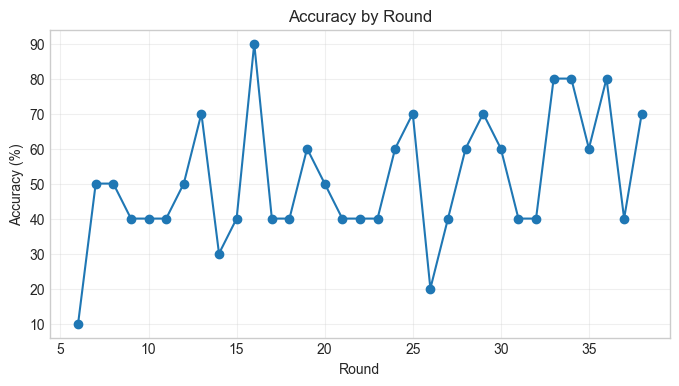

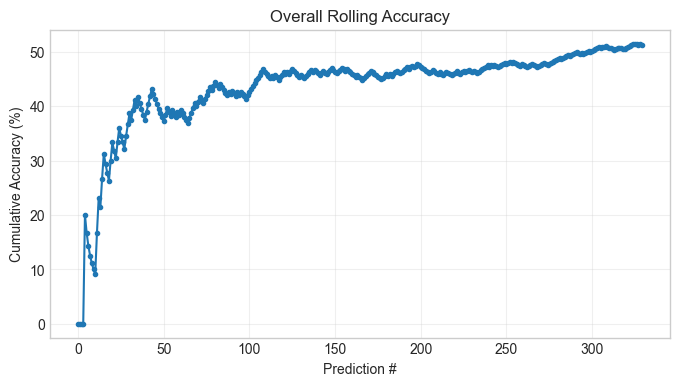

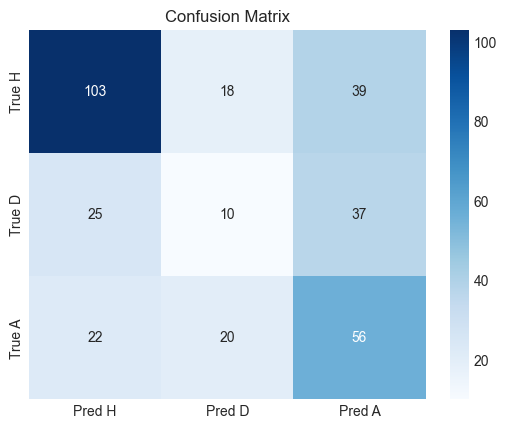


Overall accuracy (rounds 6–38): 0.512
Text summary: The model achieved an overall accuracy of 51.2% across rounds 6–38.


In [7]:
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix

# 7.1 Round-by-round accuracy
res = pd.DataFrame({'Round': rounds, 'Pred': preds, 'True': actuals})
round_acc = res.groupby('Round') \
               .apply(lambda g: accuracy_score(g['True'], g['Pred']))

plt.figure(figsize=(8,4))
plt.plot(round_acc.index, round_acc.values * 100, marker='o')
plt.xlabel('Round')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy by Round')
plt.grid(alpha=0.3)
plt.show()

# 7.2 Cumulative accuracy
cum_acc = np.cumsum(np.array(preds) == np.array(actuals)) \
          / np.arange(1, len(preds) + 1)
plt.figure(figsize=(8,4))
plt.plot(cum_acc * 100, marker='.')
plt.xlabel('Prediction #')
plt.ylabel('Cumulative Accuracy (%)')
plt.title('Overall Rolling Accuracy')
plt.grid(alpha=0.3)
plt.show()

# 7.3 Confusion matrix
cm = confusion_matrix(actuals, preds, labels=[1,0,-1])
sns.heatmap(
    cm, annot=True, fmt='d', cmap='Blues',
    xticklabels=['Pred H','Pred D','Pred A'],
    yticklabels=['True H','True D','True A']
)
plt.title('Confusion Matrix')
plt.show()

# --- Overall accuracy (text) ---
overall_acc = accuracy_score(res['True'], res['Pred'])
print(f"\nOverall accuracy (rounds {int(res['Round'].min())}–{int(res['Round'].max())}): {overall_acc:.3f}")
print(f"Text summary: The model achieved an overall accuracy of {overall_acc*100:.1f}% "
      f"across rounds {int(res['Round'].min())}–{int(res['Round'].max())}.")


8. Gradio Interface

In [8]:
import gradio as gr

# ----------------------------------------------------------------------------
# Precompute the training-set means of the odds-derived features:
# ----------------------------------------------------------------------------
odd_feats = [
    'ImpProb_H','ImpProb_D','ImpProb_A',
    'ImpOver2.5','ImpUnder2.5','OddsSpread'
]
odd_means = df[odd_feats].mean()

# ----------------------------------------------------------------------------
# Gradio dropdown choices:
# ----------------------------------------------------------------------------
teams = sorted(df['HomeTeam'].unique())
refs  = sorted(df['Referee'].unique())
times = ['Morning','Afternoon','Evening']

# ----------------------------------------------------------------------------
# Prediction function
# ----------------------------------------------------------------------------
def predict_outcome(home_team, away_team, referee, time_of_day):
    # 1) Last historical rows
    home = df[df.HomeTeam == home_team].iloc[-1]
    away = df[df.AwayTeam == away_team].iloc[-1]
    ref  = df[df.Referee == referee].iloc[-1]
    
    # 2) Assemble feature dict
    data = {}
    # 2a) Odds-derived features
    for feat in odd_feats:
        data[feat] = odd_means[feat]
    # 2b) Rolling form & streaks
    data['HomeForm3']  = home['HomeForm3']
    data['AwayForm3']  = away['AwayForm3']
    data['HomeStreak'] = home['HomeStreak']
    data['AwayStreak'] = away['AwayStreak']
    # 2c) Interaction
    data['Spread×Form'] = data['OddsSpread'] * data['HomeForm3']
    # 2d) Referee bias
    data['RefBias'] = ref['RefBias']
    # 2e) Head-to-head last result
    pair = (
        ((df.HomeTeam==home_team)&(df.AwayTeam==away_team)) |
        ((df.HomeTeam==away_team)&(df.AwayTeam==home_team))
    )
    data['H2H_Last'] = df[pair].iloc[-1]['H2H_Last']
    # 2f) Previous round positions
    data['HomePosPrev'] = home['HomePosPrev']
    data['AwayPosPrev'] = away['AwayPosPrev']
    # 2g) Rolling match-stats
    for s in home_stats:
        data[f'Home_{s}_3'] = home[f'Home_{s}_3']
    for s in away_stats:
        data[f'Away_{s}_3'] = away[f'Away_{s}_3']
    # 2h) Categorical features
    data['HomeTeam']  = home_team
    data['AwayTeam']  = away_team
    data['Referee']   = referee
    data['TimeOfDay'] = time_of_day
    
    # 3) Predict
    Xnew    = pd.DataFrame([data])
    probs   = final_model.predict_proba(Xnew)[0]
    classes = list(final_model.classes_)  # e.g. [-1,0,1]
    return (
        float(probs[classes.index(1)] * 100),
        float(probs[classes.index(0)] * 100),
        float(probs[classes.index(-1)] * 100)
    )

# ----------------------------------------------------------------------------
# Launch Gradio interface
# ----------------------------------------------------------------------------
iface = gr.Interface(
    fn=predict_outcome,
    inputs=[
        gr.Dropdown(teams, label="Home Team"),
        gr.Dropdown(teams, label="Away Team"),
        gr.Dropdown(refs,  label="Referee"),
        gr.Dropdown(times, label="Time of Day")
    ],
    outputs=[
        gr.Number(label="Home Win %"),
        gr.Number(label="Draw %"),
        gr.Number(label="Away Win %")
    ],
    title="Premier League Outcome Predictor (LightGBM)",
    description=(
        "Select Home/Away teams, Referee and Time of Day. "
        "Odds-derived features are filled with historical averages; "
        "other features come from past matches."
    )
)

iface.launch()


* Running on local URL:  http://127.0.0.1:7885

To create a public link, set `share=True` in `launch()`.
